## Description:

    Diversity estimates



In [12]:

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(lme4)
library(lmerTest)

# Loading phyloseq object

In [14]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)
sd = sample_data(physeq.Full)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


### Rarefy to minimum number of reads

In [15]:
%%R
sample_sums(physeq.Full) %>% min

[1] 4989


In [16]:
%%R
#Rarified in seperate notebook, loaded saved object
# set.seed(605)
# physeq.r = rarefy_even_depth(physeq.Full)

NULL


In [17]:
%%R
colnames(sample_data(physeq.Full))

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

# Alpha Diversity

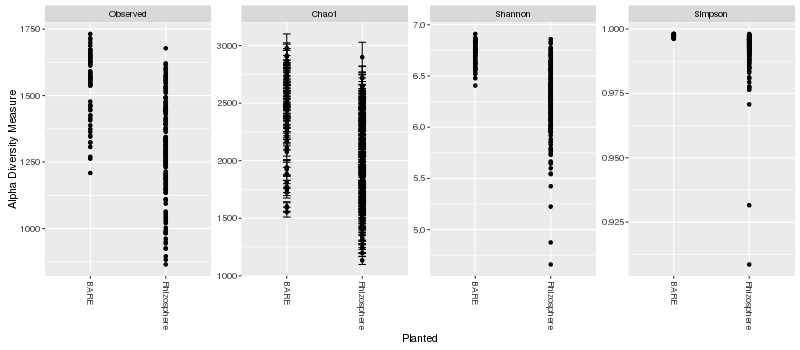

In [18]:
%%R -w 800 -h 350
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
(p <- plot_richness(physeq.Full, "Planted", measures=alpha_meas))

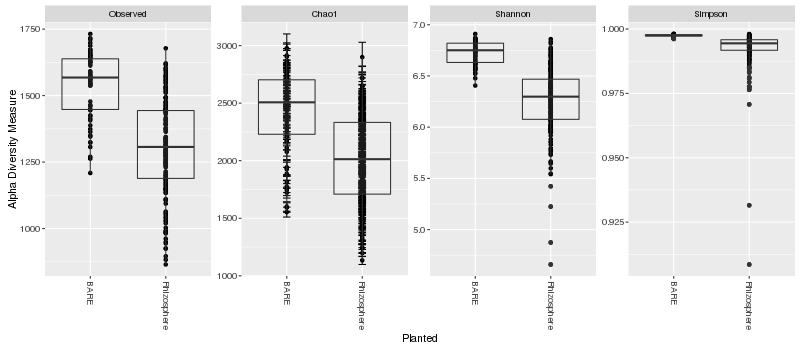

In [19]:
%%R -w 800 -h 350
p = p + geom_boxplot(data=p$data, aes(x=Planted, y=value, color=NULL), alpha=0.1)
p

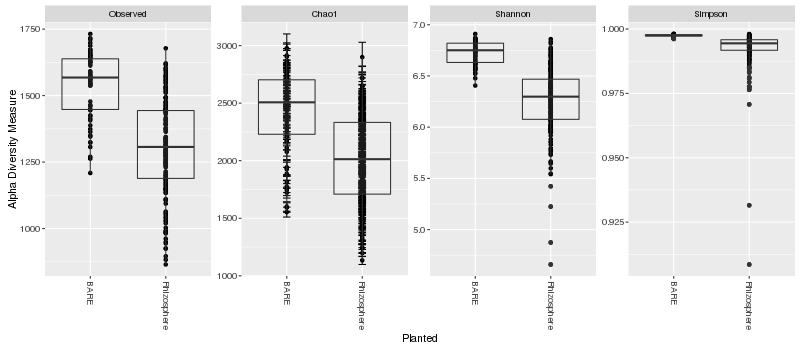

In [20]:
%%R -w 800 -h 350
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
p = plot_richness(physeq.Full, "Planted", measures=alpha_meas)
p = p + geom_boxplot(data=p$data, aes(x=Planted, y=value, color=NULL), alpha=0.1)
p

## Estimate richness

In [21]:
%%R
#rarified object
Shannon = estimate_richness(physeq.Full, measures="Shannon")
Chao1 = estimate_richness(physeq.Full, measures="Chao1")

sd = sample_data(physeq.Full) %>% tbl_df()

sd = bind_cols(sd, Shannon, Chao1)
sd$Rep = as.factor(sd$Rep)
sd$Plant = as.factor(sd$Plant)
sd$DAP = as.factor(sd$DAP)



In [22]:
%%R
#test library effects on microbial diversity

fit1 = lmer(Shannon~ Library + DAP + (1|Rep) + (1|Rep:Plant), data = sd, subset = Planted == "BARE")
summary(fit1) %>% print



Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Shannon ~ Library + DAP + (1 | Rep) + (1 | Rep:Plant)
   Data: sd
 Subset: Planted == "BARE"

REML criterion at convergence: -135.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4958 -0.5246 -0.1209  0.7552  1.6744 

Random effects:
 Groups    Name        Variance  Std.Dev.
 Rep       (Intercept) 0.0001543 0.01242 
 Rep:Plant (Intercept) 0.0001399 0.01183 
 Residual              0.0034264 0.05854 
Number of obs: 64, groups:  Rep, 4; Rep:Plant, 4

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  6.951631   0.037417 51.450000 185.790  < 2e-16 ***
Library     -0.166701   0.023976 54.630000  -6.953 4.65e-09 ***
DAP53        0.005083   0.029875 52.200000   0.170    0.866    
DAP57       -0.005804   0.029268 52.060000  -0.198    0.844    
DAP61        0.028824   0.029268 52.060000   0.985    0.329    
DAP72        0.01

In [23]:
%%R
#test sample type effects on microbial diversity

fit1 = lmer(Shannon~ Planted + DAP + Treatment + (1|Rep)  + (1|Rep:Plant), data = sd)
summary(fit1) %>% print
anova(fit1) %>% print


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Shannon ~ Planted + DAP + Treatment + (1 | Rep) + (1 | Rep:Plant)
   Data: sd

REML criterion at convergence: 72.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8387 -0.4680  0.1202  0.5872  2.4447 

Random effects:
 Groups    Name        Variance  Std.Dev.
 Rep:Plant (Intercept) 0.0378397 0.1945  
 Rep       (Intercept) 0.0004451 0.0211  
 Residual              0.0472896 0.2175  
Number of obs: 238, groups:  Rep:Plant, 91; Rep, 4

Fixed effects:
                    Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)          6.87540    0.11899  49.68000  57.780  < 2e-16 ***
PlantedRhizosphere  -0.47143    0.10496  28.28000  -4.492 0.000109 ***
DAP53               -0.20033    0.08847 222.90000  -2.264 0.024522 *  
DAP57               -0.25540    0.08746 223.78000  -2.920 0.003855 ** 
DAP61               -0.10211    0.09241 213.18000  -1.105 0.2

* DAP seems to have a significant effect 
* Nitrogen treatment was not significant and removed from the model
* Should this be done without filtering?  Phyloseq authors suggest so, but maybe other papers do it post filter
* Rhizosphere samples have significantly less diversity or evenness than bulk soil


In [24]:
%%R
sd.p = filter(sd, Plant != "BARE")

fit1 = lmer(Shannon~ Plant*Treatment  + (1|Rep) + (1|Rep:Plant), data = sd.p)
summary(fit1) %>% print
anova(fit1) %>% print



/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Correlation matrix not shown by default, as p = 44 > 12.
Use print(., correlation=TRUE)  or
	 vcov(.)	 if you need it


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Shannon ~ Plant * Treatment + (1 | Rep) + (1 | Rep:Plant)
   Data: sd.p

REML criterion at convergence: 108.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1230 -0.3618  0.0685  0.4864  2.1759 

Random effects:
 Groups    Name        Variance  Std.Dev.
 Rep:Plant (Intercept) 0.0109342 0.10457 
 Rep       (Intercept) 0.0008223 0.02868 
 Residual              0.0736795 0.27144 
Number of obs: 174, groups:  Rep:Plant, 87; Rep, 4

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                 6.463995   0.146147 127.110000  44.229  < 2e-16 ***
PlantABUTH                 -0.293621   0.205686 124.130000  -1.428  0.15594    
PlantAMAPO                 -0.580135   0.205686 124.130000  -2.820  0.00558 ** 
PlantB73                   -0.400397   0.205686 124.130000  -1.947  0.05384 .  
PlantB97             

* Treatment and Plant by Treatment interaction is not significant
* Plant is significant

### Graph Shannon index by plant

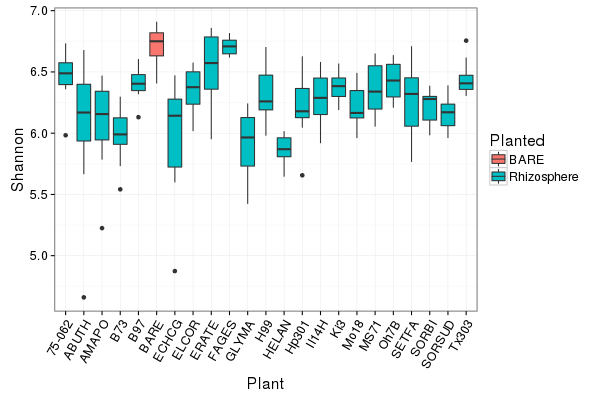

In [32]:
%%R -w 600 -h 400
p = ggplot(sd, aes(Plant, Shannon))
p = p + geom_boxplot(aes(fill = Planted))
p = p + theme_bw(base_size = 16)
p = p + theme(axis.text.x = element_text(angle = 60, hjust = 1))

p1 = p
p1

### Graph Chao1 index by plant

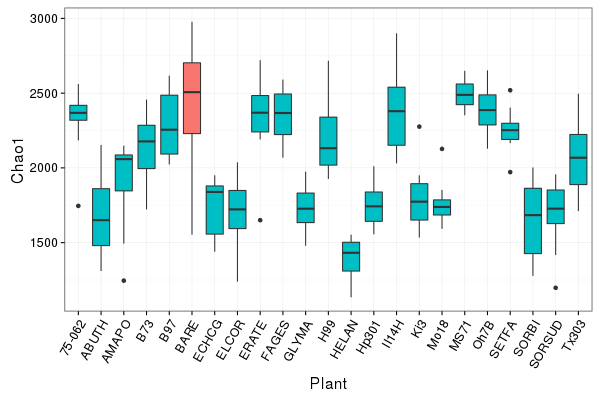

In [34]:
%%R -w 600 -h 400
p = ggplot(sd, aes(Plant, Chao1))
p = p + geom_boxplot(aes(fill = Planted))
p = p + theme_bw(base_size = 16)
p = p + theme(axis.text.x = element_text(angle = 60, hjust = 1))
p = p + theme(legend.position = "none")


p2 = p
p2


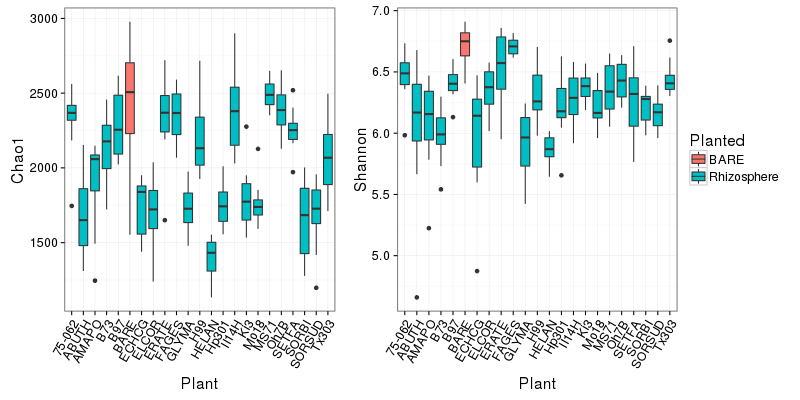

In [38]:
%%R -w 800 -h 400
grid.arrange(p2, p1, ncol = 2,  widths=c(.9,1.2))

In [27]:
%%R

fit1 = lmer(Chao1~ Planted*Treatment  + (1|Rep) + (1|Rep:Plant), data = sd)
summary(fit1) %>% print
anova(fit1) %>% print

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Chao1 ~ Planted * Treatment + (1 | Rep) + (1 | Rep:Plant)
   Data: sd

REML criterion at convergence: 3419.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2668 -0.3989  0.1067  0.4991  2.1559 

Random effects:
 Groups    Name        Variance Std.Dev.
 Rep:Plant (Intercept) 87121    295.16  
 Rep       (Intercept)  2085     45.66  
 Residual              74792    273.48  
Number of obs: 238, groups:  Rep:Plant, 91; Rep, 4

Fixed effects:
                                 Estimate Std. Error      df t value Pr(>|t|)
(Intercept)                       2472.41     156.97   50.89  15.751   <2e-16
PlantedRhizosphere                -444.24     161.18   53.07  -2.756    0.008
TreatmentNpos                     -107.19      68.37  141.50  -1.568    0.119
PlantedRhizosphere:TreatmentNpos    57.35      79.96  141.50   0.717    0.474
                                    

In [29]:
%%R
sd %>% 
    group_by(Planted) %>%
    summarize(Hmean = mean(Shannon),
             Chao1mean = mean(Chao1))

# A tibble: 2 x 3
      Planted    Hmean Chao1mean
        <chr>    <dbl>     <dbl>
1        BARE 6.722941  2418.812
2 Rhizosphere 6.254570  2003.021


In [30]:
%%R
sd.p = filter(sd, Plant != "BARE")
fit2 = lmer(Chao1~ Plant*Treatment  + (1|Rep) + (1|Rep:Plant), data = sd.p)
summary(fit2) %>% print
anova(fit2) %>% print

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Chao1 ~ Plant * Treatment + (1 | Rep) + (1 | Rep:Plant)
   Data: sd.p

REML criterion at convergence: 1835.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.98299 -0.45652  0.00127  0.47656  2.00960 

Random effects:
 Groups    Name        Variance Std.Dev.
 Rep:Plant (Intercept) 22678    150.59  
 Rep       (Intercept)  5932     77.02  
 Residual              30612    174.96  
Number of obs: 174, groups:  Rep:Plant, 87; Rep, 4

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)               2376.355    121.678   78.890  19.530  < 2e-16 ***
PlantABUTH                -621.605    163.232  105.630  -3.808 0.000235 ***
PlantAMAPO                -529.792    163.232  105.630  -3.246 0.001570 ** 
PlantB73                  -214.813    163.232  105.630  -1.316 0.191025    
PlantB97                  -168.578  

# Exploratory - factors correlated with shannon index work in progress

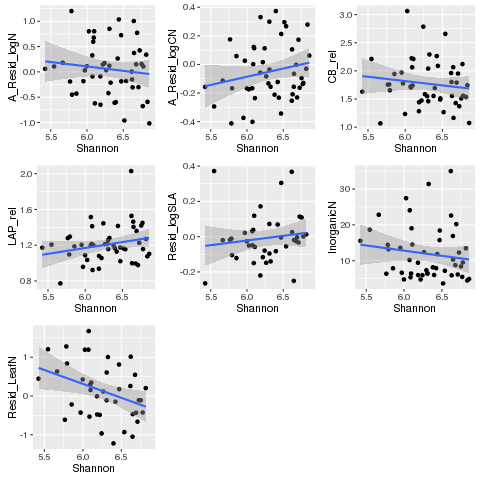

In [36]:
%%R
# remove Shannon outliers
data = sd.p
data = filter(data, Shannon > 5.4)
data = filter(data, InorganicN < 50)
# data = filter(data, Treatment == "Nneg")
data = filter(data, Type != "Maize")

p = ggplot(data, aes(Shannon, A_Resid_logN))
p = p + geom_point()
p = p + stat_smooth(method = "lm")

p3 = ggplot(data, aes(Shannon, A_Resid_logCN))
p3 = p3 + geom_point()
p3 = p3 + stat_smooth(method = "lm")

p1 = ggplot(data, aes(Shannon, CB_rel))
p1 = p1 + geom_point()
p1 = p1 + stat_smooth(method = "lm")


p2 = ggplot(data, aes(Shannon, LAP_rel))
p2 = p2 + geom_point()
p2 = p2 + stat_smooth(method = "lm")

p4 = ggplot(data, aes(Shannon, Resid_logSLA))
p4 = p4 + geom_point()
p4 = p4 + stat_smooth(method = "lm")

p5 = ggplot(data, aes(Shannon, InorganicN))
p5 = p5 + geom_point()
p5 = p5 + stat_smooth(method = "lm")

p6 = ggplot(data, aes(Shannon, Resid_LeafN))
p6 = p6 + geom_point()
p6 = p6 + stat_smooth(method = "lm")

grid.arrange(p, p3, p1, p2,p4,p5, p6, ncol = 3)

In [37]:
%%R
fit3 = lmer(Shannon~InorganicN + (1|Rep) + (1|Plant), data = data)
print("InorganicN")
anova(fit3) %>% print

fit1 = lmer(Shannon~A_Resid_logN  + (1|Rep), data = data)
print("A_Resid_logN")
anova(fit1) %>% print # Interaction of Shannon and Treatment is not significant, plant must be included in model 
# for Shannon to be significant 

fit2 = lmer(LAP_rel~Shannon + Plant + Shannon:Plant  + (1|Rep), data = data)
print("LAP_rel")
anova(fit2) %>% print #3way interaction marginal = .08, interaction of Shannon and plant is significant



fit4 = lmer(CB_rel~Shannon  + (1|Rep) + (1|Plant), data = data)
print("CB_rel")
anova(fit4) %>% print

fit5 = lmer(Shannon~A_Resid_logCN + (1|Rep) + (1|Plant), data = data)
anova(fit5) %>% print

fit6 = lmer(Shannon~Type + (1|Rep) + (1|Plant), data = data)
anova(fit6) %>% print


# fit7 = lmer(Shannon~Resid_LeafN + (1|Rep) + (1|Plant), data = data)
# anova(fit7) %>% print


[1] "InorganicN"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
            Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
InorganicN 0.10816 0.10816     1 46.303  1.4852 0.2291
[1] "A_Resid_logN"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
               Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
A_Resid_logN 0.091908 0.091908     1    47 0.68727 0.4113
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
               Sum Sq  Mean Sq NumDF  DenDF F.value  Pr(>F)  
Shannon       0.08771 0.087709     1 33.437  3.4818 0.07084 .
Plant         0.37784 0.062973     6 33.581  2.4998 0.04145 *
Shannon:Plant 0.36858 0.061430     6 33.649  2.4386 0.04572 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
    